In [2]:
import fooof
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cycler
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy.io import loadmat

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# Investigating spectra

Some questions: 
- will spectral exponents reflect anything interesting?
    - fg.get_params('aperiodic_params', 'exponent') where fg object is 
- Why is the non averaged spectrum so varied?
    - How to see statistics for this?
- How do oscillations relate to dipole brain region?

Other things:
- To see goodness of fit: fg.get_params('r_squared')

Relevant resources
- https://fooof-tools.github.io/fooof/#

## FOOOF Settings

`peak_width_limits` sets the possible lower- and upper-bounds for the fitted peak widths.

`max_n_peaks sets` the maximum number of peaks to fit.

`min_peak_height` sets an absolute limit on the minimum height (above aperiodic) for any extracted peak.

`peak_threshold` sets a relative threshold above which a peak height must cross to be included in the model.

`aperiodic_mode` defines the approach to use to parameterize the aperiodic component.

## Parameter returns `.get_params()` 
[full docs here](https://fooof-tools.github.io/fooof/generated/fooof.FOOOF.html#fooof.FOOOF.get_params)

`peak_params`
- CF: center frequency of the extracted peak
- PW: power of the peak, over and above the aperiodic component
- BW: bandwidth of the extracted peak

`aperiodic_params`
- exponent

## FOOOF Group on each cluster

- First just calling FOOOF group on averaged spectra, the kind we see in the study plotting with 4 curves (for dipole only clustering (Brian))
- What do we want in our dataframe?

#### Refs
- https://fooof-tools.github.io/fooof/generated/fooof.FOOOFGroup.html



Need to change `min_peak_height` to find components w/o oscillations

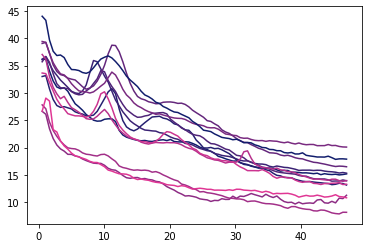

In [36]:
p_spectrum = loadmat('./data/spectra/dip_only/brian_diponly_{}_spectra.mat'.format(8))
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = specdata.mean(0)[0]
fg = fooof.FOOOFGroup(aperiodic_mode='fixed', verbose = False)
# fg.fit(specfreqs, group_spec.T, [3, 50])

cmap = LinearSegmentedColormap.from_list('mycmap', ['#111d6c', '#e03694'])
n_ = group_spec.shape[0]
color = cmap(np.linspace(0, 1,11))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for i in range(12):
    plt.plot(specfreqs[:84], group_spec[:,i][:84])
plt.show()

[ 9.28023838 12.644938   18.37099369 25.0982312 ]
[0.16584438 0.06846433 0.11952614 0.04397775]


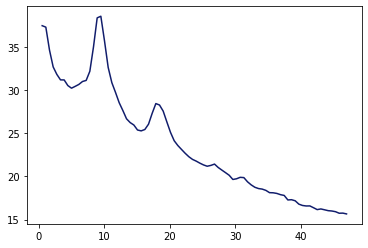

In [27]:
plt.plot(specfreqs[:84], group_spec[:,5][:84])
five = group_spec[:,5][:84]
fg = fooof.FOOOF(aperiodic_mode='fixed', verbose = False)
fg.fit(specfreqs[:84], five, [3, 90])
cfs = pws = fg.get_params('peak_params', 'CF')
pws = fg.get_params('peak_params', 'PW')
print(cfs)
print(pws)

In [61]:
def load_and_fit(dimension, freqrange, aperiodic_mode = 'fixed', min_peak_height = 0):
    """dimension: if 'condition', averages across components
                  if 'component', averages across conditions
    """
    group_df = dict.fromkeys(['cluster {}'.format(i) for i in range(3,15)])

    for k in group_df.keys():
        group_df[k] = {'spectral exponent':None, 'peak data':None, 'r2':None}

    for i in range(3,15):
        p_spectrum = loadmat('./data/spectra/dip_only/brian_diponly_{}_spectra.mat'.format(i))
        specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
        if dimension == 'condition':
            group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])# shaped 4x229, averaged across 16 components
            
        elif dimension == 'component':
            group_spec = specdata.mean(0)[0] # 16 x 229
        
        fg = fooof.FOOOFGroup(aperiodic_mode=aperiodic_mode, min_peak_height = min_peak_height, verbose = False)
        
        if dimension == 'condition':
            fg.fit(specfreqs, group_spec, freqrange)
        elif dimension == 'component':
            fg.fit(specfreqs, group_spec.T, freqrange)
            
        group_df['cluster {}'.format(i)]['spectral exponent'] = fg.get_params('aperiodic_params', 'exponent')
        group_df['cluster {}'.format(i)]['peak data'] = { 'CF': fg.get_params('peak_params', 'CF'), 
                                                          'PW': fg.get_params('peak_params', 'PW'), 
                                                          'BW': fg.get_params('peak_params', 'BW') }
        group_df['cluster {}'.format(i)]['r2'] = fg.get_params('r_squared')
    
    return group_df

group_df = load_and_fit(dimension = 'component', freqrange = [3,50], min_peak_height = 0.02)

In [52]:
def peakPlot(fit_data, param, bins = plt.rcParams["hist.bins"], plt_format = 'layered'):
    """param: 'CF', 'PW', or 'BW' 
    plt_format: either 'layered' or 'subplots' 
    """
    colors = plt.cm.brg(np.linspace(0, 1,12))
    for i, cl in enumerate(range(3,15)):
        peaks = fit_data['cluster {}'.format(cl)]['peak data'][param][:,0] #because peak_data for FOOOFgroup is stored as [data, spectral curve #]
        if plt_format == 'subplots':
            plt.subplot(3,4,i+1)
        plt.hist(peaks, color =colors[i], alpha=0.5, bins = bins)
        if param == 'CF':
            plt.xlim(0,50)
            plt.locator_params(axis='x', tight=True, nbins=15)
        
        if param == 'CF':
            if plt_format == 'subplots':
                plt.title('Distribution of Peak Frequencies Clus {}'.format(cl))
            else:
                plt.title('Distribution of Peak Frequencies')
            plt.xlabel('Center Frequency'); plt.ylabel('counts')
        plt.tight_layout()

def peakDataScatter(fit_data, measures = ['CF', "BW"]):
    """Scatter plot of peak measures, default CF vs BW"""
    m1, m2 = measures[0], measures[1]
    colors = plt.cm.brg(np.linspace(0, 1,12))
    for i, cl in enumerate(range(3,15)):
        peaks = group_df['cluster {}'.format(cl)]['peak data'][m1][:,0] #because peak_data for FOOOFgroup is stored as [data, spectral curve #]
        pk_widths = group_df['cluster {}'.format(cl)]['peak data'][m2][:,0]
        plt.subplot(3,4,i+1)
        plt.scatter(peaks, pk_widths, color = colors[i], alpha = 0.7)
        plt.xlabel(m1); plt.ylabel(m2)
        plt.tight_layout()
    
def exponentPlot(fit_data, bins = plt.rcParams["hist.bins"], plt_format = 'layered'):
    """plt_format: either 'layered' or 'subplots' 
    """
    colors = plt.cm.winter(np.linspace(0, 1,12))
    for i, cl in enumerate(range(3,15)):
        peaks = fit_data['cluster {}'.format(cl)]['spectral exponent']
        if plt_format == 'subplots':
            plt.subplot(3,4,i+1)
        plt.hist(peaks, color =colors[i], alpha=0.5, bins = bins) 
        
        if plt_format == 'subplots':
            plt.title('Distribution of Aperiodic Exponents Clus {}'.format(cl))
        else:
            plt.title('Distribution of Aperiodic Exponents')
        plt.tight_layout()
    plt.xlabel('Aperiodic Exponent'); plt.ylabel('counts')
    
def peakDistr(fit_data, plt_format = 'subplots', order = 'unsorted'):
    """Plot distribution of peak heights (above aperiodic)"""
    colors = plt.cm.brg(np.linspace(0, 1,12))
    for i, cl in enumerate(range(3,15)):
        peaks = fit_data['cluster {}'.format(cl)]['peak data']['CF'][:,0]
        powers = fit_data['cluster {}'.format(cl)]['peak data']['PW'][:,0]
        a = 0.3 # for layered case
        if plt_format == 'subplots':
            plt.subplot(3,4,i+1)
            a = 0.7
        if order == 'sorted':
            plt.bar(list(range(len(peaks))), sorted(powers), color = colors[i], alpha = a)
        else:
            plt.bar(peaks, powers, color = colors[i], alpha = a)
        plt.xlabel('freq'); plt.ylabel('power')
        plt.tight_layout()

In [89]:
for i, cl in enumerate(range(3,15)):
    peaks = group_df['cluster {}'.format(cl)]['peak data']['CF'][:,0]
    print('===Cluster {} oscillation freqs ==='.format(cl))
    peaks = sorted(peaks)
    for p in peaks:
        print('{:1.1f}'.format(p), end = ', ') #print with 1 decimal place
    #print(peaks)
    print('\n')

===Cluster 3 oscillation freqs ===
6.6, 6.6, 6.7, 6.7, 10.1, 10.2, 10.2, 10.3, 20.0, 20.7, 21.4, 22.3, 27.2, 28.5, 29.5, 

===Cluster 4 oscillation freqs ===
10.0, 10.0, 10.8, 10.8, 12.1, 12.3, 19.8, 19.9, 20.0, 20.1, 

===Cluster 5 oscillation freqs ===
10.1, 10.2, 10.3, 10.3, 12.9, 18.7, 18.7, 18.8, 19.0, 30.8, 30.9, 31.0, 31.1, 

===Cluster 6 oscillation freqs ===
10.8, 10.8, 10.8, 10.9, 15.6, 19.7, 20.3, 20.5, 20.7, 29.8, 30.3, 

===Cluster 7 oscillation freqs ===
11.2, 11.2, 11.4, 11.4, 20.5, 20.6, 20.6, 20.7, 

===Cluster 8 oscillation freqs ===
10.6, 10.7, 10.7, 10.7, 19.3, 19.7, 19.7, 19.8, 30.0, 30.1, 30.2, 30.8, 

===Cluster 9 oscillation freqs ===
6.6, 6.6, 6.6, 6.7, 12.0, 12.0, 12.3, 12.6, 19.7, 21.3, 21.5, 21.5, 26.6, 

===Cluster 10 oscillation freqs ===
6.6, 7.2, 10.1, 10.3, 10.5, 22.1, 26.1, 28.8, 30.4, 30.6, 30.9, 31.0, 31.2, 34.8, 35.6, 35.7, 37.7, 37.8, 41.8, 47.8, 

===Cluster 11 oscillation freqs ===
11.2, 11.3, 11.3, 11.3, 20.6, 20.6, 20.7, 20.8, 

===Cluster 12 o

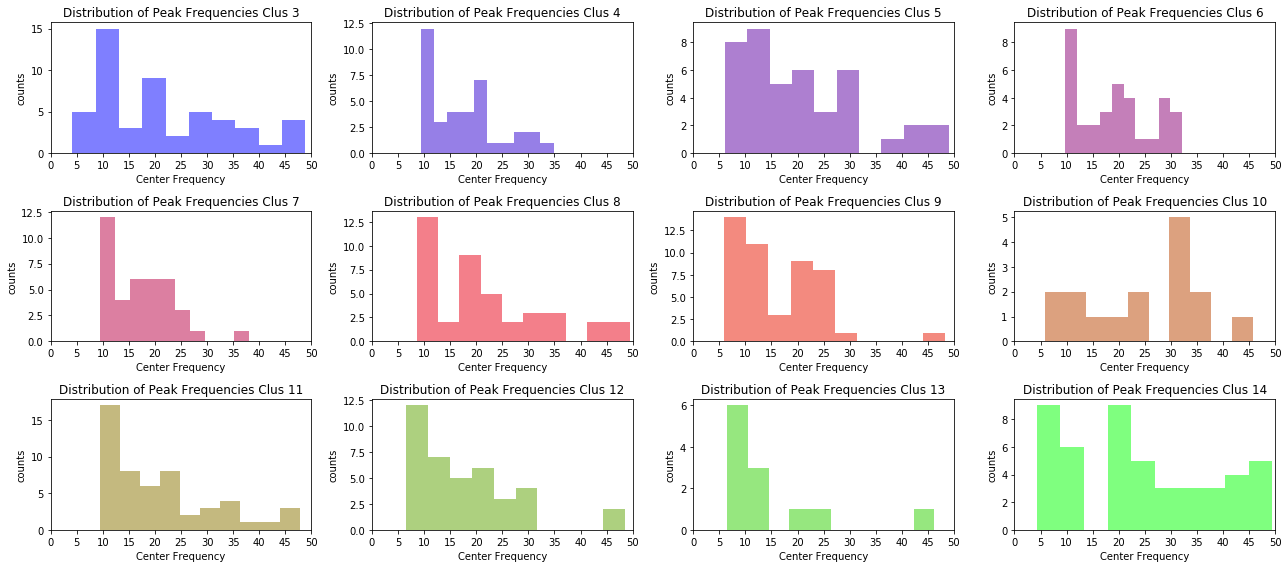

In [62]:
plt.figure(figsize=[18,8])
peakPlot(group_df, 'CF', plt_format = 'subplots')

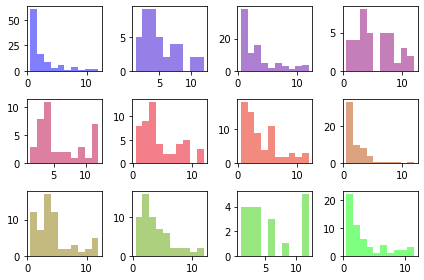

In [84]:
peakPlot(group_df, 'BW', plt_format = 'subplots')
plt.show()

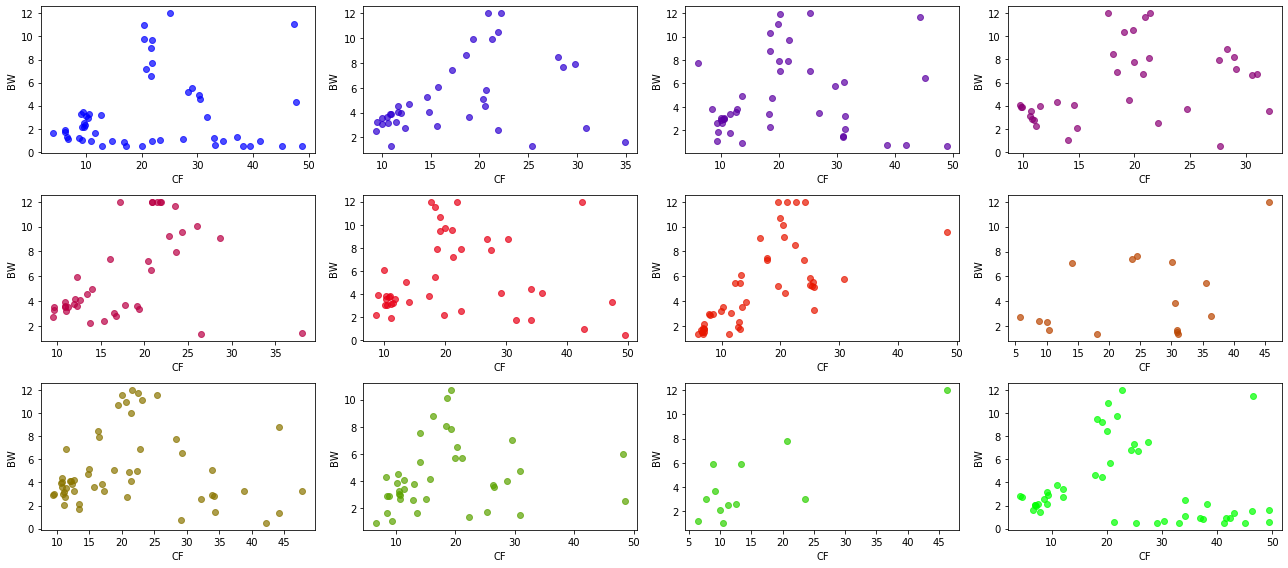

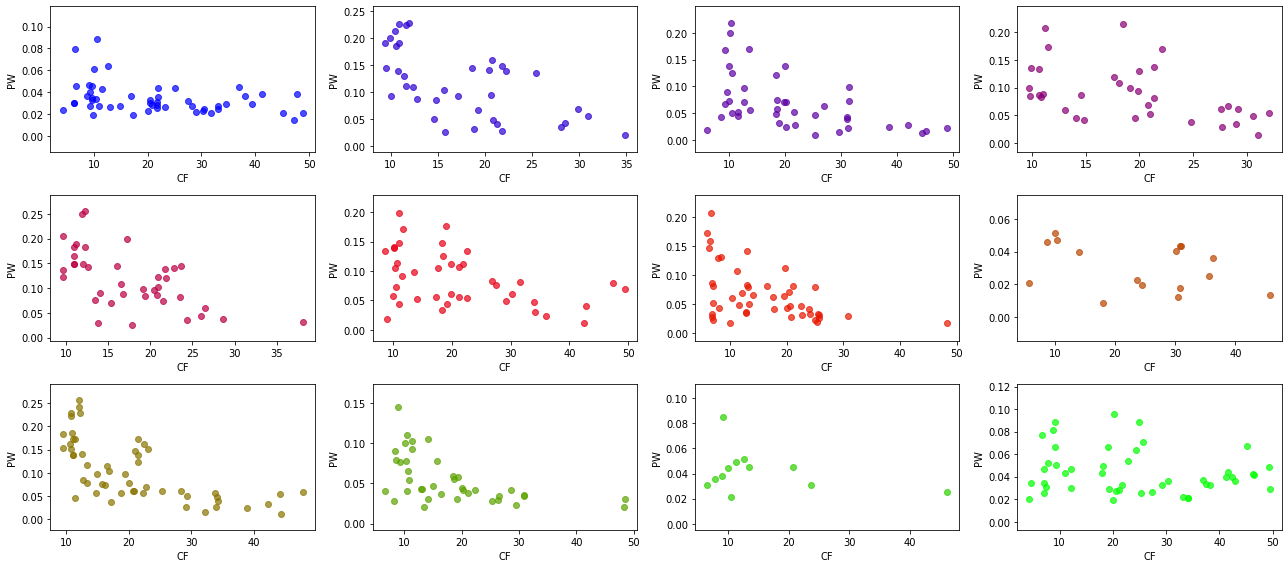

In [63]:
plt.figure(figsize=[18,8])
peakDataScatter(group_df)
plt.figure(figsize=[18,8])
peakDataScatter(group_df, measures = ['CF','PW'])

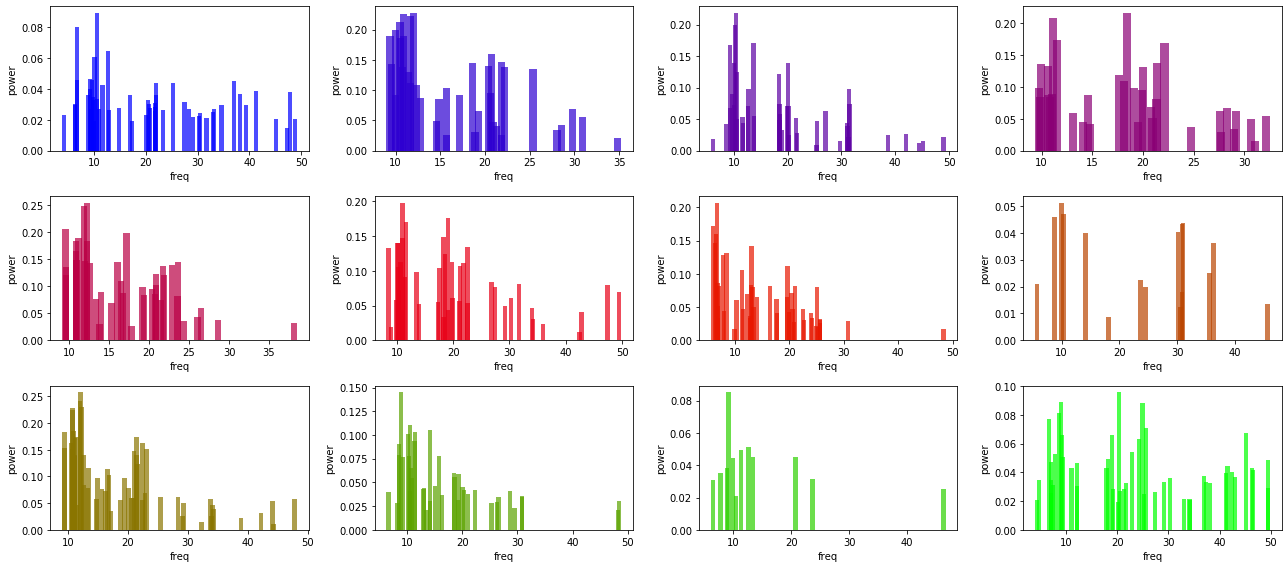

In [64]:
plt.figure(figsize=[18,8])
#peakDistr(group_df, order = 'sorted')
#peakDistr(group_df, plt_format = 'layered')
peakDistr(group_df)

# Comparison chart
Originally done in MATLAB for ERPs

indices: PL, PR, TL, TR

In [65]:
group_df2 = load_and_fit(dimension = 'condition', freqrange = [3,50], aperiodic_mode = 'fixed')
peaks = []
for i, cl in enumerate(range(3,15)):
    peaks.append(group_df2['cluster {}'.format(cl)]['peak data']['CF']) #[:,0]) 
oscillations = {'delta' : [0.5,3], 'theta' : [3,8], 'alpha' : [8,12], 'beta' : [12,38], 'gamma' : [38,42]}

In [ ]:
diffs = dict()
for o in oscillations.keys():
    #print('++++++OSC', o)
    o_range = oscillations[o]
    min_, max_ = o_range[0], o_range[1]
    o_diffs = {'x':[], 'y':[], 'cl':[]} # to have x and y arrays
    
    for i, cl in enumerate(range(3,15)):
        o_peaks = [] # peaks at oscillation o for cluster cl
        clus_peaks = peaks[i]
        for peak in clus_peaks:
            if min_ <= peak[0] <= max_:
                o_peaks.append(peak)
                
        if len(o_peaks) == 4:
            RL_P = o_peaks[1][0] - o_peaks[0][0]; RL_T = o_peaks[3][0] - o_peaks[2][0] # PR - PL; TR- TL
            PT_L = o_peaks[0][0] - o_peaks[2][0]; PT_R = o_peaks[1][0] - o_peaks[3][0] # PL - TL ; PR - TR

            RL = np.mean([RL_P, RL_T]) # mean([(PR - PL), (TR - TL)])
            PT = np.mean([PT_L, PT_R]) # mean([(PL - TL), (PR - TR)]) 

            o_diffs['x'].append(RL)
            o_diffs['y'].append(PT)
            o_diffs['cl'].append('cl {}'.format(cl))
        #print('CLUS',cl,'\n', o_peaks)        
    
    if len(o_diffs['x']) != 0:
        diffs[o] = o_diffs

In [67]:
diffs

{'theta': {'x': [-0.08680361150564186, 0.03704432570380778],
  'y': [0.04182335217699018, 0.05192588886547167],
  'cl': ['cl 3', 'cl 9']},
 'alpha': {'x': [-0.09272057725712912,
   0.018083587979476512,
   0.04891779011771291,
   -0.08377120796709292,
   0.024787504089762713,
   0.023430945101637235,
   0.04293199392230829,
   -0.22207106728027437],
  'y': [0.13891695477638955,
   0.7927065249927674,
   0.07882452694524567,
   0.07136470901501113,
   -0.17630207916493656,
   -0.06326344224873104,
   -0.04868630856796319,
   0.3720370385723628],
  'cl': ['cl 3', 'cl 4', 'cl 5', 'cl 6', 'cl 7', 'cl 8', 'cl 11', 'cl 13']},
 'beta': {'x': [-0.04246403199874038,
   0.05754903155081159,
   -0.023002530070872496],
  'y': [-0.07457819552240252, 0.06454492851117699, -0.4952673900227893],
  'cl': ['cl 7', 'cl 11', 'cl 14']}}

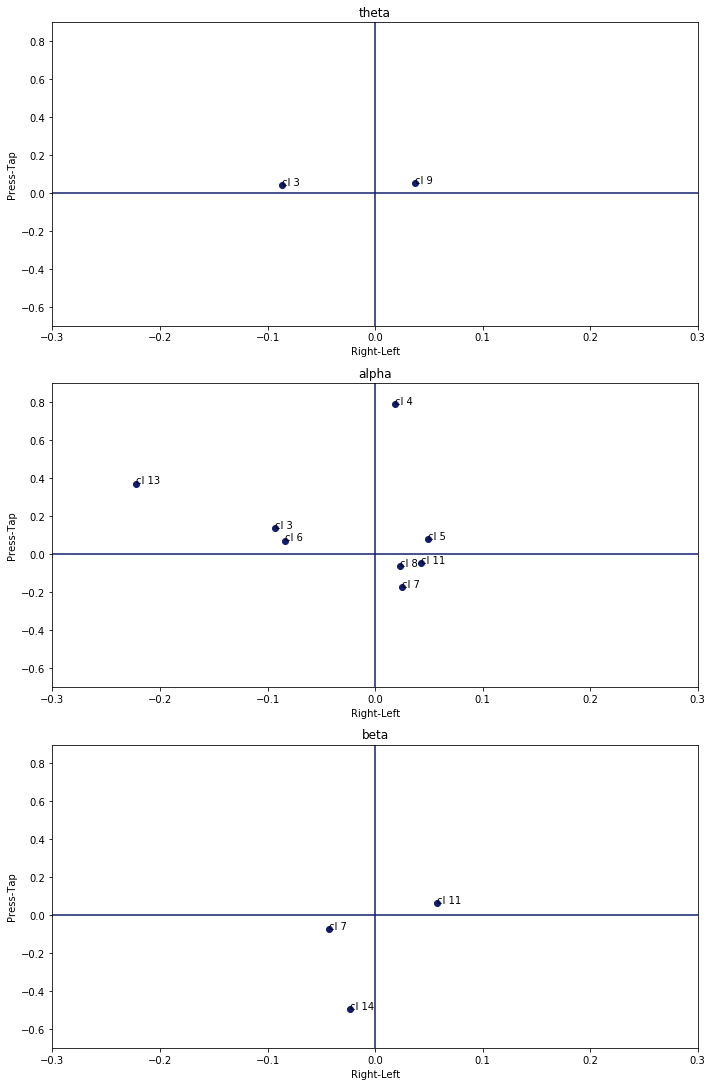

In [68]:
plt.figure(figsize=[10,15])
for i, o in enumerate(diffs.keys()):
    plt.subplot(3,1,i+1)
    x, y = diffs[o]['x'], diffs[o]['y']
    plt.scatter(x,y)
    plt.ylim([-0.7, 0.9]); plt.xlim([-0.3, 0.3])
    for t_i, txt in enumerate(diffs[o]['cl']):
        plt.annotate(txt, (x[t_i], y[t_i]))
    plt.axhline(0); plt.axvline(0)
    plt.tight_layout()
    
    plt.title(o)
    plt.xlabel('Right-Left'); plt.ylabel('Press-Tap');

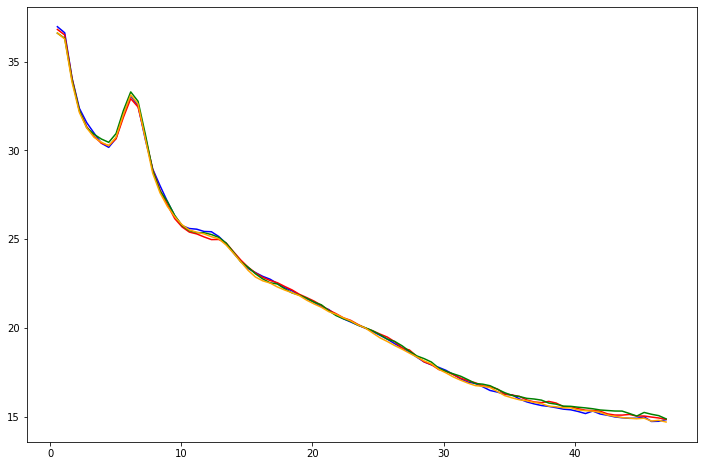

In [132]:
p_spectrum = loadmat('./data/spectra/dip_only/brian_diponly_{}_spectra.mat'.format(9))
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])
colors = ['b','r','g','orange'] # PL, PR, TL, TR
plt.figure(figsize=[12,8])
for i in range(4):
    plt.plot(specfreqs[:84], group_spec[i][:84], color = colors[i])

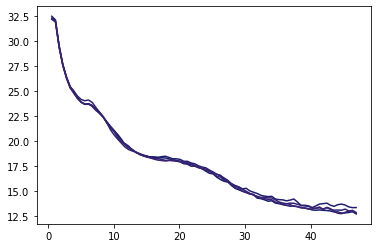

In [128]:
p_spectrum = loadmat('./data/spectra/dip_only/brian_diponly_{}_spectra.mat'.format(14))
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])
colors = ['b','r','g','orange']
for i in range(4):
    plt.plot(specfreqs[:84], group_spec[i][:84])

# Single FOOOF
- fitting for just PL, PR, TL, TR (Wait!  FOOOF_group already does this so not that necessary!)

In [ ]:
single_spec_fit = dict.fromkeys(['cluster {}'.format(i) for i in range(3,15)])
for k in single_spec_fit.keys():
    single_spec_fit[k] = {'PR':[], 'PL':[], 'TL':[], 'TR':[]}    

# Some tests 
Just to see how to use FOOOF and how to load exported spectral data
- Notice the variance in the non averaged spectrum.  

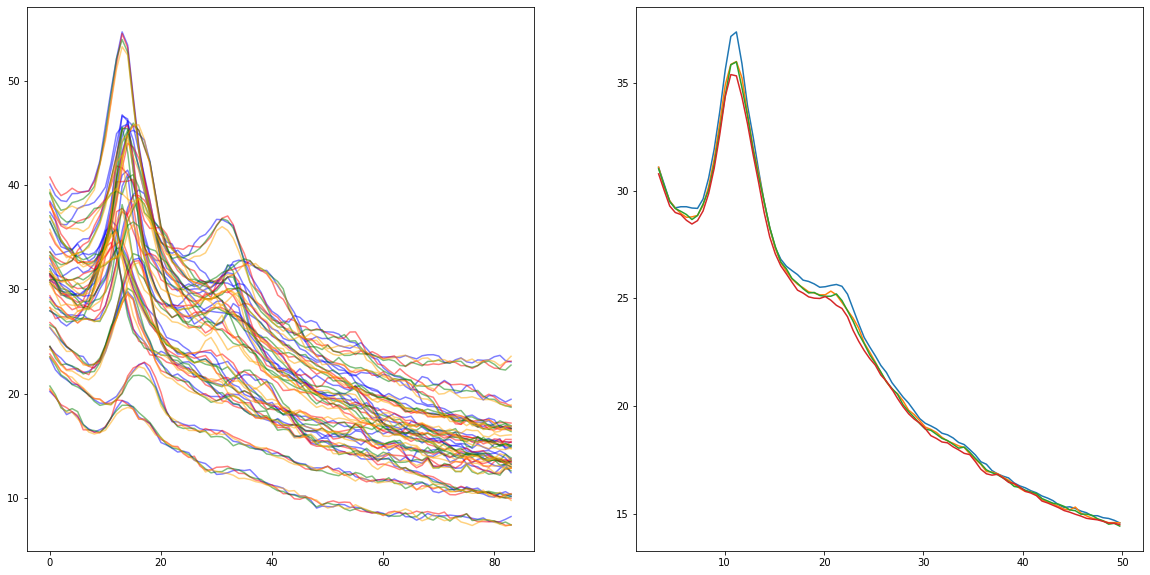

In [6]:
# data from dipole location + ERSP clustering; cluster 5
p_spectrum = loadmat('./data/spectra/dip5_specdata.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']

group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
colors = ['b','r','g','orange']
for i in range(4):
    plt.plot(specdata[i][0], color = colors[i], alpha = 0.5)

plt.subplot(1,2,2)
for i in range(4):
    plt.plot(specfreqs, group_spec[i])
    
#plt.legend()

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
            

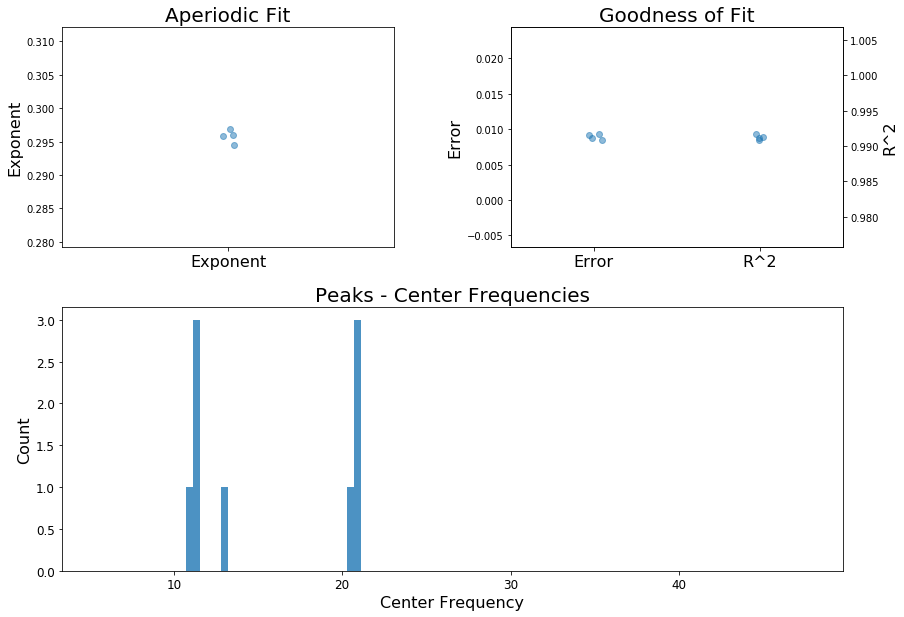

In [42]:
fg = fooof.FOOOFGroup()
fg.fit(specfreqs, group_spec)
freqrange = [3,50]
fg.report(specfreqs, group_spec, freqrange)

## Single FOOOF - One condition


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

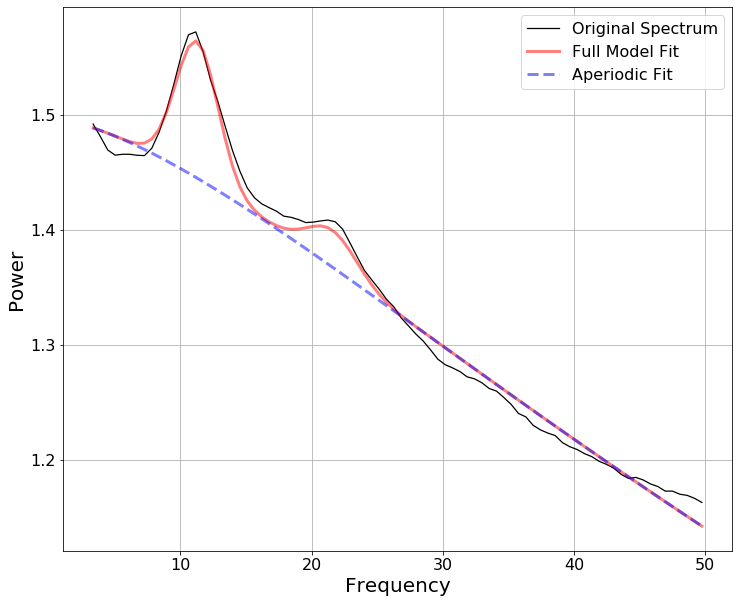

In [4]:
fg = fooof.FOOOF(aperiodic_mode='knee')
fg.fit(specfreqs, group_spec[0])
freqrange = [3,50]
fg.report(specfreqs, group_spec[0], freqrange)

# All dipole only clusters

This spectrum has 229 points for some reason

In [10]:
dip_only_spec = loadmat('./data/dip_only/brian_diponly_all_spectra.mat')


In [18]:
dip_only_spec['specdata'][0][0].shape


(229, 11)

In [20]:
dip_only_spec['specfreqs'].shape

(1, 229)

In [29]:
dip_only_spec3 = loadmat('./data/dip_only/brian_diponly_3_spectra.mat')
specfreqs3, specdata3 = dip_only_spec3['specfreqs'][0], dip_only_spec3['specdata']

group_spec3 = np.array([specdata3[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

In [30]:
dip_only_spec3['specdata'][0][0].shape

(229, 18)

In [34]:
group_spec3.shape

(4, 229)

In [33]:
group_spec.shape

(4, 84)